In [1]:
import logging
import numpy as np
from time import time
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
logging.basicConfig(level = logging.INFO, 
                    format = '%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person = 70, 
                              resize = 0.4)

In [3]:
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel_positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, y_test.shape

((966, 1850), (966,), (322,))

#### Viewing target_names then asign to a `label_dictionary`

In [5]:
label_dict = {n : target_names[n] for n in range(len(target_names))}
label_dict

{0: 'Ariel Sharon',
 1: 'Colin Powell',
 2: 'Donald Rumsfeld',
 3: 'George W Bush',
 4: 'Gerhard Schroeder',
 5: 'Hugo Chavez',
 6: 'Tony Blair'}

### Viewing insight-dataset

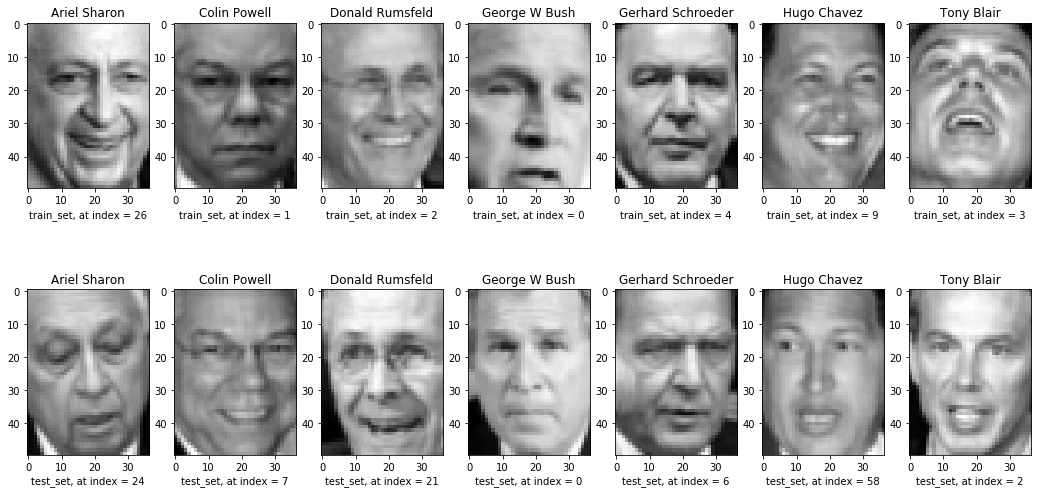

In [6]:
plt.figure(figsize = [18, 9])
for k in range(7): 
    ## Find the first_index of a list(y_train) equals to a values k (from 0 - 6)
    id_train = y_train.tolist().index(k)
    
    ## Plot the difference_people_faces in the training set
    plt.subplot(2, 7, k+1)
    plt.imshow(X_train[id_train].reshape(h, w), cmap = 'gray')
    plt.title(str(label_dict[y_train[id_train]]))
    plt.xlabel("train_set, at index = " + str(id_train))

    ## Plot the difference_people_faces in the testing set
    plt.subplot(2, 7, k + 8)
    id_test = y_test.tolist().index(k)
    plt.imshow(X_test[id_test].reshape(h, w), cmap = 'gray')
    plt.title(str(label_dict[y_test[id_test]]))
    plt.xlabel("test_set, at index = " + str(id_test))

### Choosing the `n_components`

In [7]:
pca_955 = PCA(0.955).fit(X)
n_components = pca_955.n_components_
n_components

154

#### Compute a PCA (`eigenfaces`) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [8]:
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 154 eigenfaces from 966 faces
done in 0.085s


**Transforming by using projection onto orthonormal basis**

In [9]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s


### Viewing `eigenfaces`

In [10]:
tit = ['eigenface.shape :\t', 'X_train.shape :\t\t', 'X_test.shape :\t\t', 'X_train_pca.shape :\t']
shape = eigenfaces.shape, X_train.shape, X_test.shape, X_train_pca.shape
for idx in range(4):
    print(tit[idx], shape[idx])

eigenface.shape :	 (154, 50, 37)
X_train.shape :		 (966, 1850)
X_test.shape :		 (322, 1850)
X_train_pca.shape :	 (966, 154)


Viewing the first 5 eigen-faces:


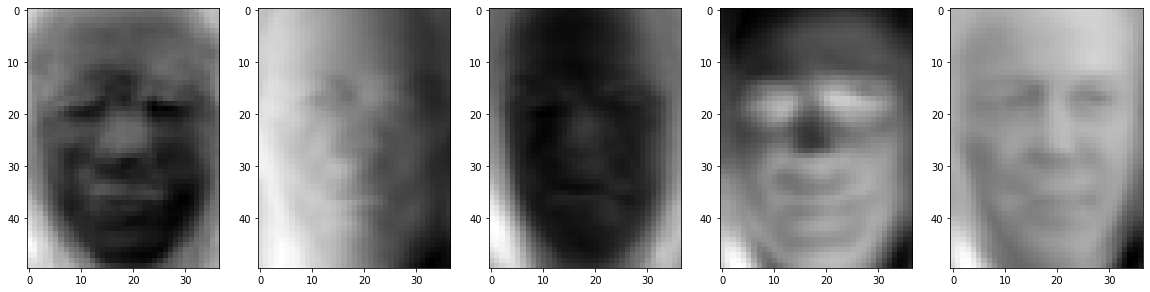

In [11]:
print("Viewing the first 5 eigen-faces:")
fig, axes = plt.subplots(1, 5, figsize = (20, 5))
for k in range(5):
    axes[k].imshow(eigenfaces[k], cmap = 'gray')

### Train a SVM classification model

In [12]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e-2, 1, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 45.436s
Best estimator found by grid search:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Quantitative evaluation of the model quality on the test set

In [13]:
from sklearn.metrics import accuracy_score

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.051s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.62      0.62        13
     Colin Powell       0.66      0.93      0.77        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.95      0.92      0.93       146
Gerhard Schroeder       0.96      0.88      0.92        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.86       322
        macro avg       0.85      0.77      0.80       322
     weighted avg       0.88      0.86      0.86       322

[[  8   5   0   0   0   0   0]
 [  2  56   0   1   0   1   0]
 [  2   5  18   2   0   0   0]
 [  0  12   0 134   0   0   0]
 [  0   1   0   1  22   0   1]
 [  0   4   0   1   1   9   0]
 [  1   2   2   2   0   0  29]]


In [14]:
y_pred_train = clf.predict(X_train_pca)
y_pred_test = clf.predict(X_test_pca)

print('Train_acc = %.4f \nTest_acc = %.4f'%
      (accuracy_score(y_pred_train, y_train), accuracy_score(y_pred_test, y_test)))

Train_acc = 0.9896 
Test_acc = 0.8571


### Visualized evaluation of the forecasting's result

In [15]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=7):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]        

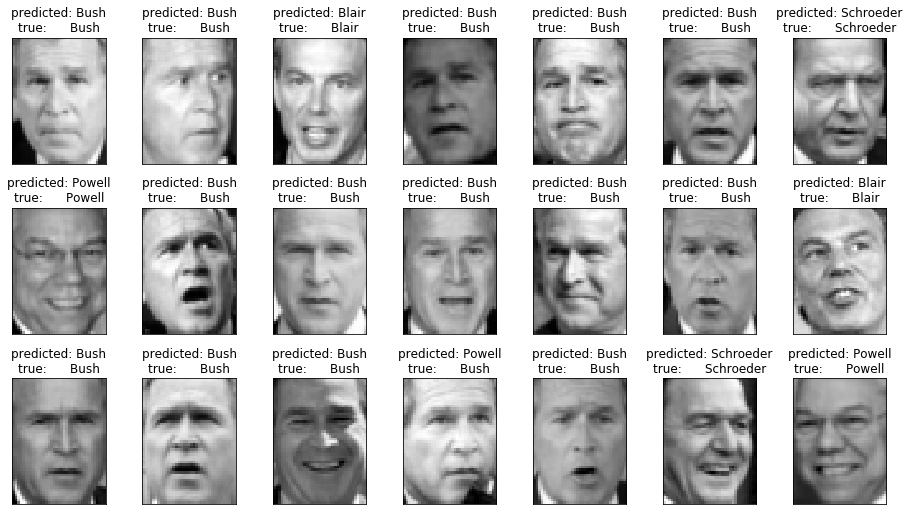

In [16]:
plot_gallery(X_test, prediction_titles, h, w)
plt.show()

In these `forecasting visualization` on the first 21 `image-faces` on the `test-set`, the `forecast` is `wrong` only **1** at the middle at the bottom of plot:
> **Prediced = Powell**; but
>
> **Actual = Bush**

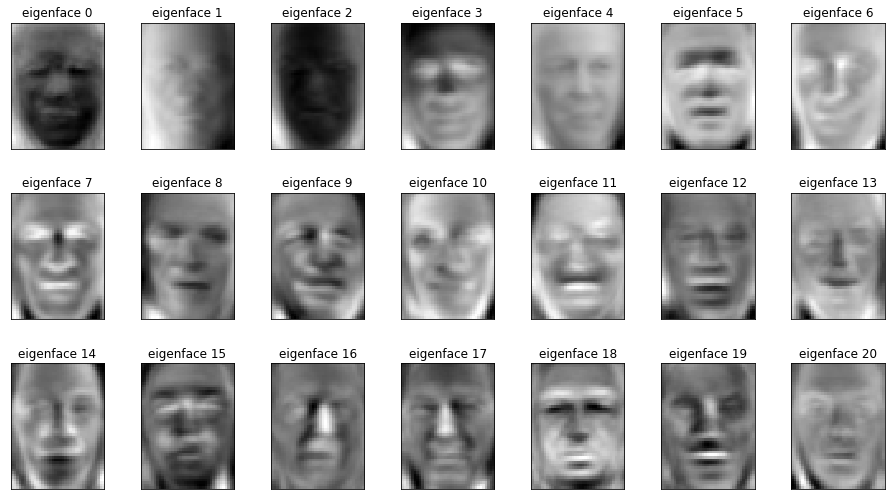

In [17]:
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

### How about using `StandardScaler` before `PCA` in this case?

In [18]:
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()
X_train_sc = ssc.fit_transform(X_train)
X_test_sc = ssc.fit_transform(X_test)

pca = PCA(0.955)
pca.fit(X_train_sc)
n_components = pca.n_components_
X_train_sc_pca = pca.transform(X_train_sc)
X_test_sc_pca = pca.transform(X_test_sc)
eigenfaces = pca.components_.reshape((n_components, h, w))
print("We need %s components to keep at least 0.955 information"%n_components)

We need 149 components to keep at least 0.955 information


In [19]:
print("Fitting the classifier to the training set")
t0 = time()
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_sc_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 46.797s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [20]:
y_pred_train = clf.predict(X_train_sc_pca)
y_pred_test = clf.predict(X_test_sc_pca)

print('Confusion matrix: \n', confusion_matrix(y_pred_test, y_test))

print('Train_acc = %.4f \nTest_acc = %.4f'%
      (accuracy_score(y_pred_train, y_train), accuracy_score(y_pred_test, y_test)))

print('Classification report: \n', classification_report(y_pred_test, y_test))

Confusion matrix: 
 [[  9   3   4   2   0   0   2]
 [  1  52   2   7   1   3   2]
 [  2   0  16   2   0   0   1]
 [  1   3   4 127   1   1   2]
 [  0   0   1   2  20   1   2]
 [  0   1   0   1   1   9   0]
 [  0   1   0   5   2   1  27]]
Train_acc = 1.0000 
Test_acc = 0.8075
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.45      0.55        20
           1       0.87      0.76      0.81        68
           2       0.59      0.76      0.67        21
           3       0.87      0.91      0.89       139
           4       0.80      0.77      0.78        26
           5       0.60      0.75      0.67        12
           6       0.75      0.75      0.75        36

    accuracy                           0.81       322
   macro avg       0.74      0.74      0.73       322
weighted avg       0.81      0.81      0.81       322



Using `StandarScaler` before `PCA` can improve the `train_acc` to `1` but the `test_acc` is about `0.81`, so this is not a `good choice` to `evaluate` this dataset!

### Visualization

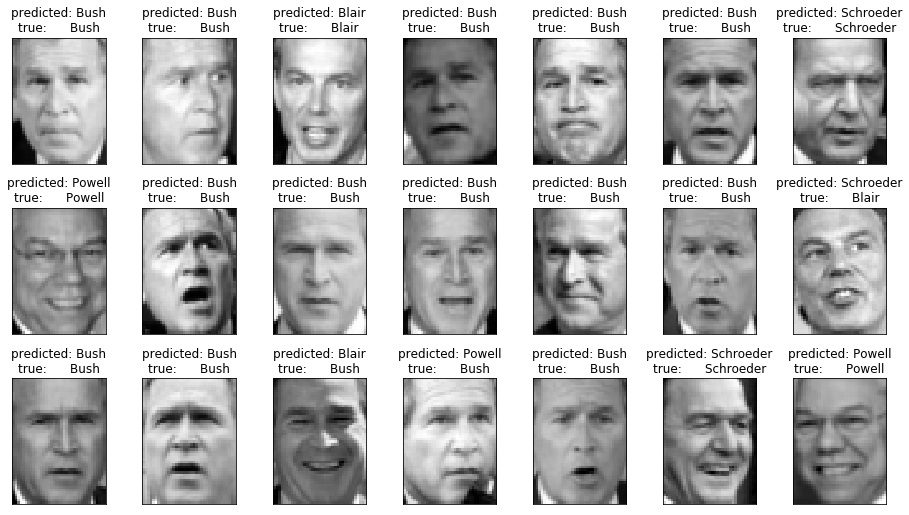

In [23]:
prediction_titles = [title(y_pred_test, y_test, target_names, i)
                     for i in range(y_pred_test.shape[0])]        
plot_gallery(X_test, prediction_titles, h, w)
plt.show()

Now, looking back **`Line [16]`** then compared them!

> Using `PCA()` only wrong **1** over the first 21 image-faces on the test-set (`Predicted = Powell` while `Acutal = Bush`)
>
> Here, using `StandardScaler` then `PCA` get wrong **3 (times)** over the first 21 images; look at the last column in the second row (`predicted = Schroeder` while `true =` `"Blair"`) and the 3rd (`predicted = Blair, true = Bush`), 4th (`predicted = Powell, true = Bush`) columns at the last row

### And using `StandardScaler` after `PCA`

In [24]:
ssc = StandardScaler()
pca = PCA(0.955)
pca.fit(X_train)
n_components = pca.n_components_

X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
X_train_pca_sc = ssc.fit_transform(X_train_pca)
X_test_pca_sc = ssc.fit_transform(X_test_pca)
eigenfaces = pca.components_.reshape((n_components, h, w))
print("We need %s components to keep at least 0.955 information"%pca.n_components_)

We need 146 components to keep at least 0.955 information


In [25]:
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca_sc, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

done in 1051.619s
Best estimator found by grid search:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [26]:
y_pred_train = clf.predict(X_train_pca_sc)
y_pred_test = clf.predict(X_test_pca_sc)

print('Confusion matrix: \n', confusion_matrix(y_pred_test, y_test))

print('Train_acc = %.4f \nTest_acc = %.4f'%
      (accuracy_score(y_pred_train, y_train), accuracy_score(y_pred_test, y_test)))

print('Classification report: \n', classification_report(y_pred_test, y_test))

Confusion matrix: 
 [[ 11   2   1   2   0   0   1]
 [  1  56   3  11   1   3   2]
 [  0   0  17   0   0   0   2]
 [  0   1   6 130   1   0   1]
 [  1   0   0   2  22   1   2]
 [  0   1   0   1   0  11   0]
 [  0   0   0   0   1   0  28]]
Train_acc = 0.9855 
Test_acc = 0.8540
Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.65      0.73        17
           1       0.93      0.73      0.82        77
           2       0.63      0.89      0.74        19
           3       0.89      0.94      0.91       139
           4       0.88      0.79      0.83        28
           5       0.73      0.85      0.79        13
           6       0.78      0.97      0.86        29

    accuracy                           0.85       322
   macro avg       0.81      0.83      0.81       322
weighted avg       0.87      0.85      0.85       322



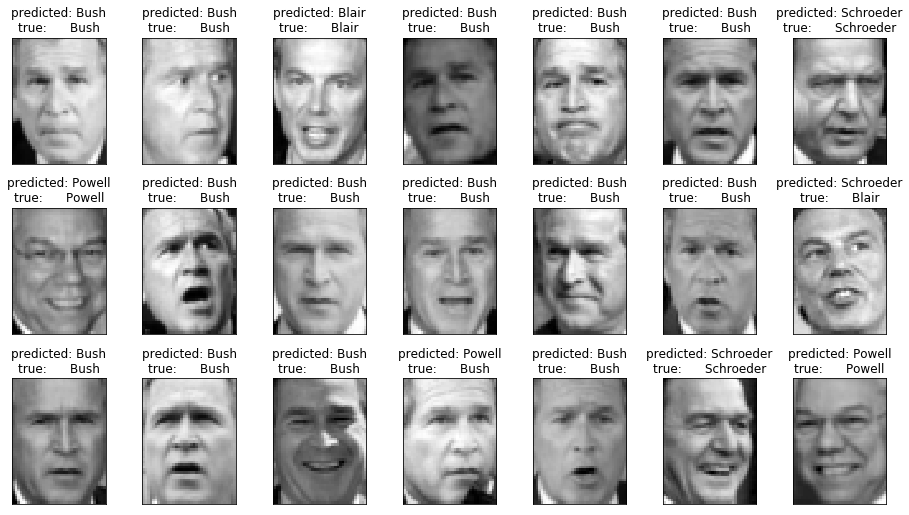

In [28]:
prediction_titles = [title(y_pred_test, y_test, target_names, i)
                     for i in range(y_pred_test.shape[0])]        
plot_gallery(X_test, prediction_titles, h, w)
plt.show()

**Comments**

- Looking back **Line [20]**, although using `StandarScaler` before `PCA` can improve the `train_acc` to `1` but the `test_acc` is about `0.81`, which is `overfitting`!!

- There is **not** any `significant differences` between using `PCA()` and `PCA +(then) StandardScaler`, according to **Lines [14, 26]**